<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Kahn's Topological Sorting Algorithm</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm

import networkx as nx
import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 65ae48c468991275ad13ee5f183953d270e667f1

pandas    : 1.1.3
matplotlib: 3.3.2
json      : 2.0.9
watermark : 2.1.0
networkx  : 2.5
numpy     : 1.19.2
tqdm      : 4.62.0



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Toy Graph

Let us define a small toy graph

In [4]:
G = nx.DiGraph()
G.add_edge(5, 2)
G.add_edge(5, 0)
G.add_edge(4, 0)
G.add_edge(4, 1)
G.add_edge(2, 3)
G.add_edge(3, 1)

We can easily plot it using one of the standard graph layout algorithsm

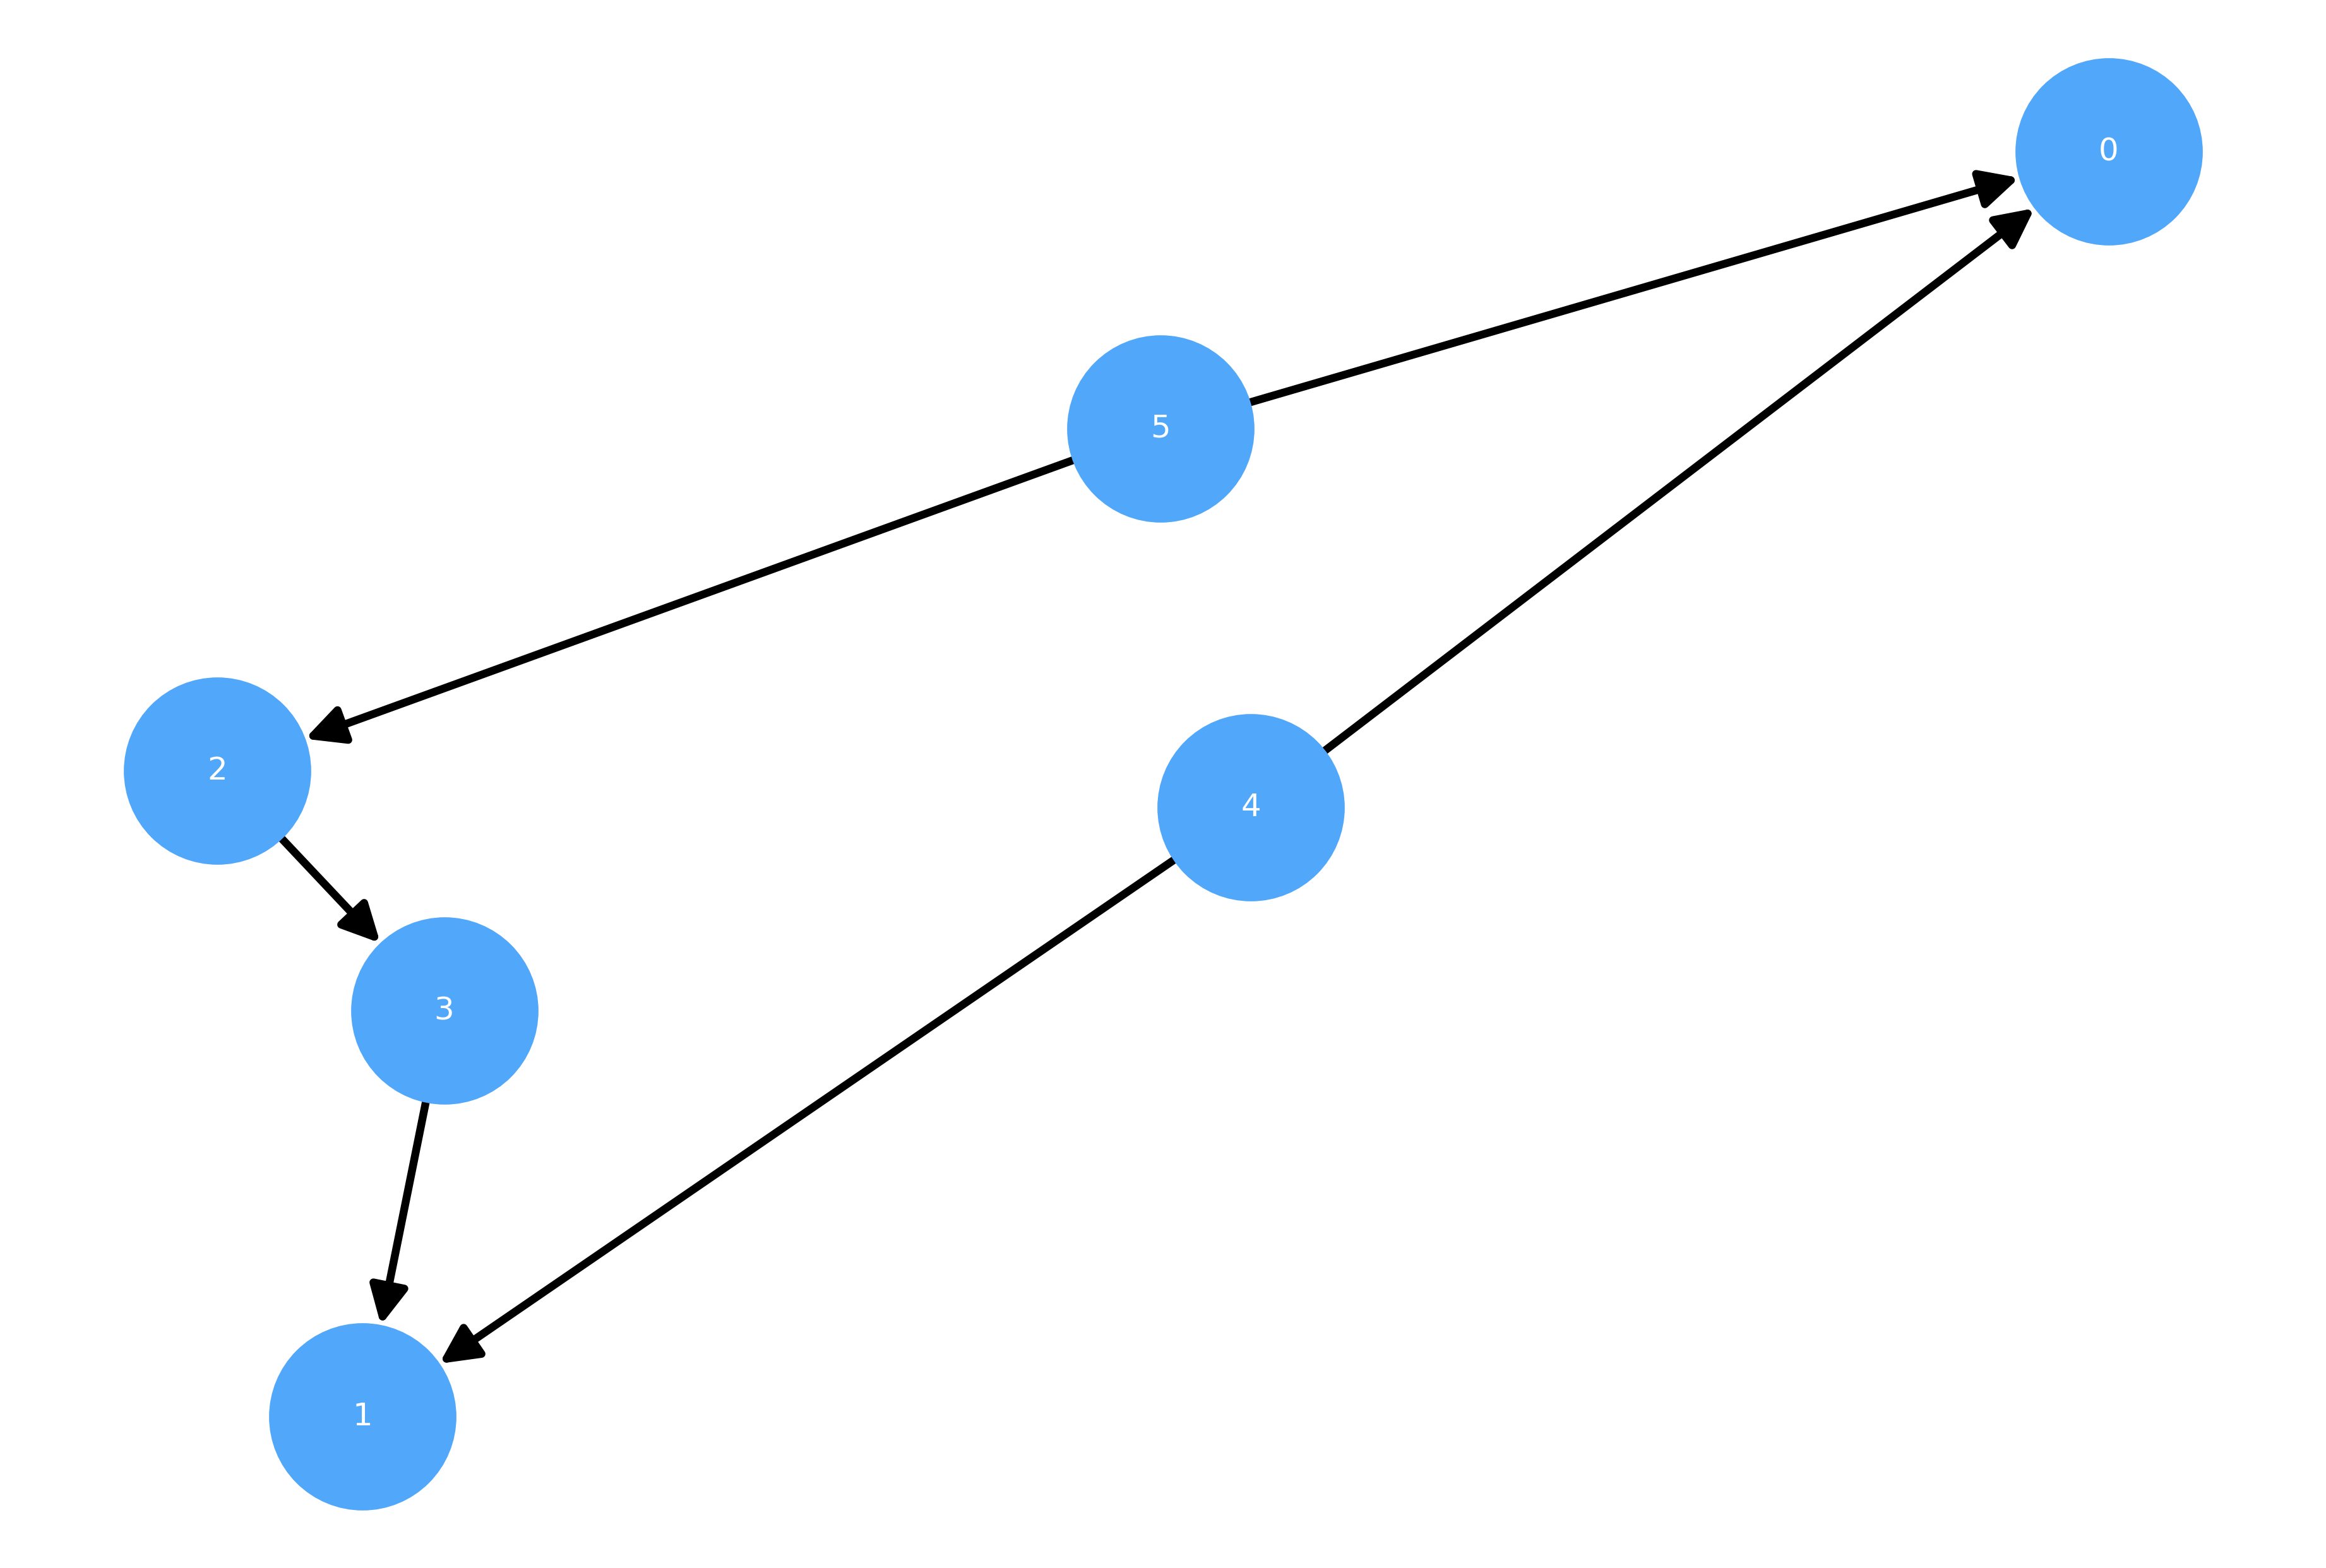

In [5]:
np.random.seed(123)
pos = nx.layout.fruchterman_reingold_layout(G)

fig, ax = plt.subplots(1)
nx.draw(G, node_size=5000, pos=pos,  node_color=colors[0], ax=ax, 
        width=3, arrowsize=30)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax);

Let us identify which nodes have zero in-degree

In [6]:
degrees = dict(G.in_degree())
zero_degree_nodes = [node for node, deg in degrees.items() if deg == 0]

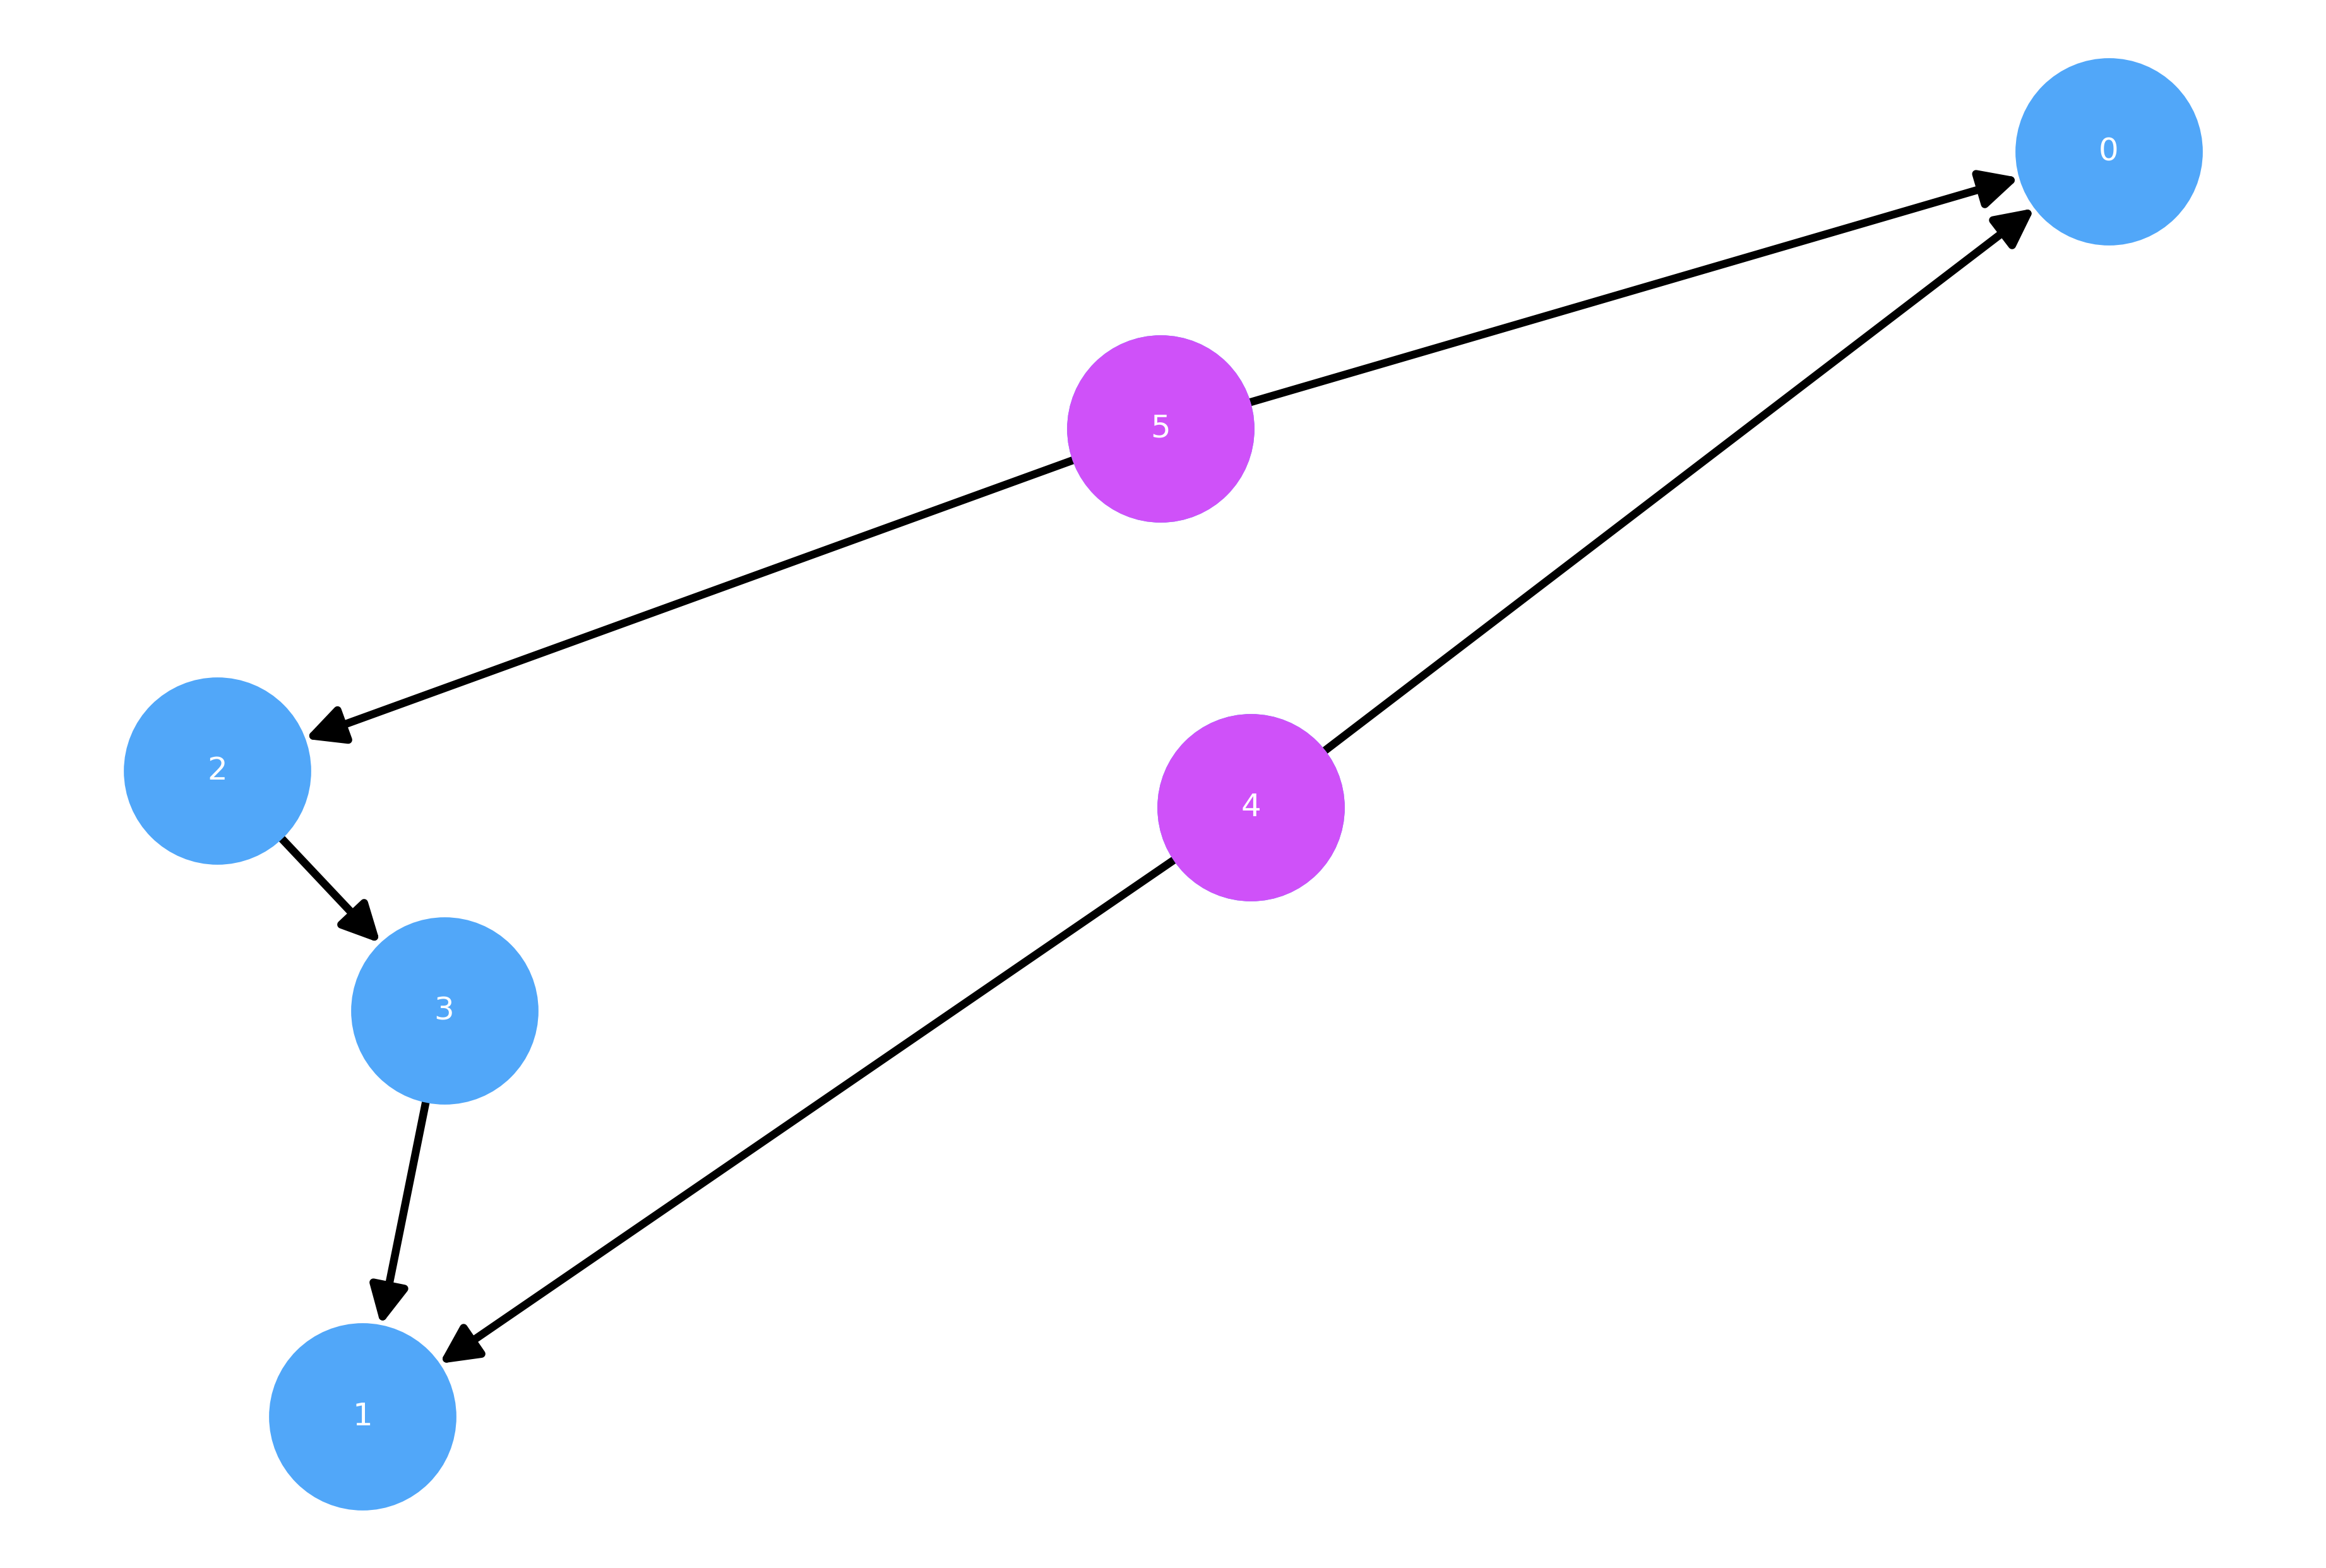

In [7]:
np.random.seed(123)
pos = nx.layout.fruchterman_reingold_layout(G)

fig, ax = plt.subplots(1)
nx.draw(G, node_size=5000, pos=pos,  node_color=colors[0], ax=ax, 
        width=3, arrowsize=30)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)
nx.draw_networkx_nodes(G, pos=pos, nodelist=zero_degree_nodes, 
                       node_color=colors[1], node_size=5000)

# Topological Sorting

Implementing Kahn's Algorithm is straightforward. Here we add a small modification so that we can keep track of the "depth" (distance from the initial set of zero degree nodes) of each node.

In [8]:
def kahns_algorithm(G):
    # Extract the in-degree of each node
    degrees = dict(G.in_degree())
    
    # Initialize the queue with all the zero-degree nodes
    queue = [node for node in degrees if degrees[node] == 0]

    nodes_visited = 0
    node_order = []
    depth = {}
    
    # Keep track of the "depth" at which 
    # we encounter each node
    for node in queue:
        depth[node] = 0

    # While the queue is not empty
    while queue:
        node_i = queue.pop(0)
        node_order.append(node_i)
        
        # Update the degree of each of the neighbors
        for node_j in G.neighbors(node_i):
            degrees[node_j] -= 1
            
            # If in-degree becomes zero, add it to queue
            if degrees[node_j] == 0:
                queue.append(node_j)
                depth[node_j] = depth[node_i] + 1
            
            # Increment the number of visited nodes
            nodes_visited += 1
    
    print("Ordered %u nodes out of %u." % (len(depth), G.number_of_nodes()))
    return node_order, depth

In [9]:
 node_order, depth = kahns_algorithm(G)

Ordered 6 nodes out of 6.


Now we can easily calculate a position for each node. The depth corresponds to the position along the x axis, and we increment the position along the y direction whenever we have more than one node at the same depth

In [10]:
def compute_layout(depth):
    pos = {}

    loc = 0
    old_value = None
    for node, value in depth.items():
        if value != old_value:
            loc = 0
        else:
            loc += 1

        pos[node] = (value, loc)
        old_value = value

    return pos

In [11]:
pos = compute_layout(depth)

The end result makes the functioning of the algorithm quite clear

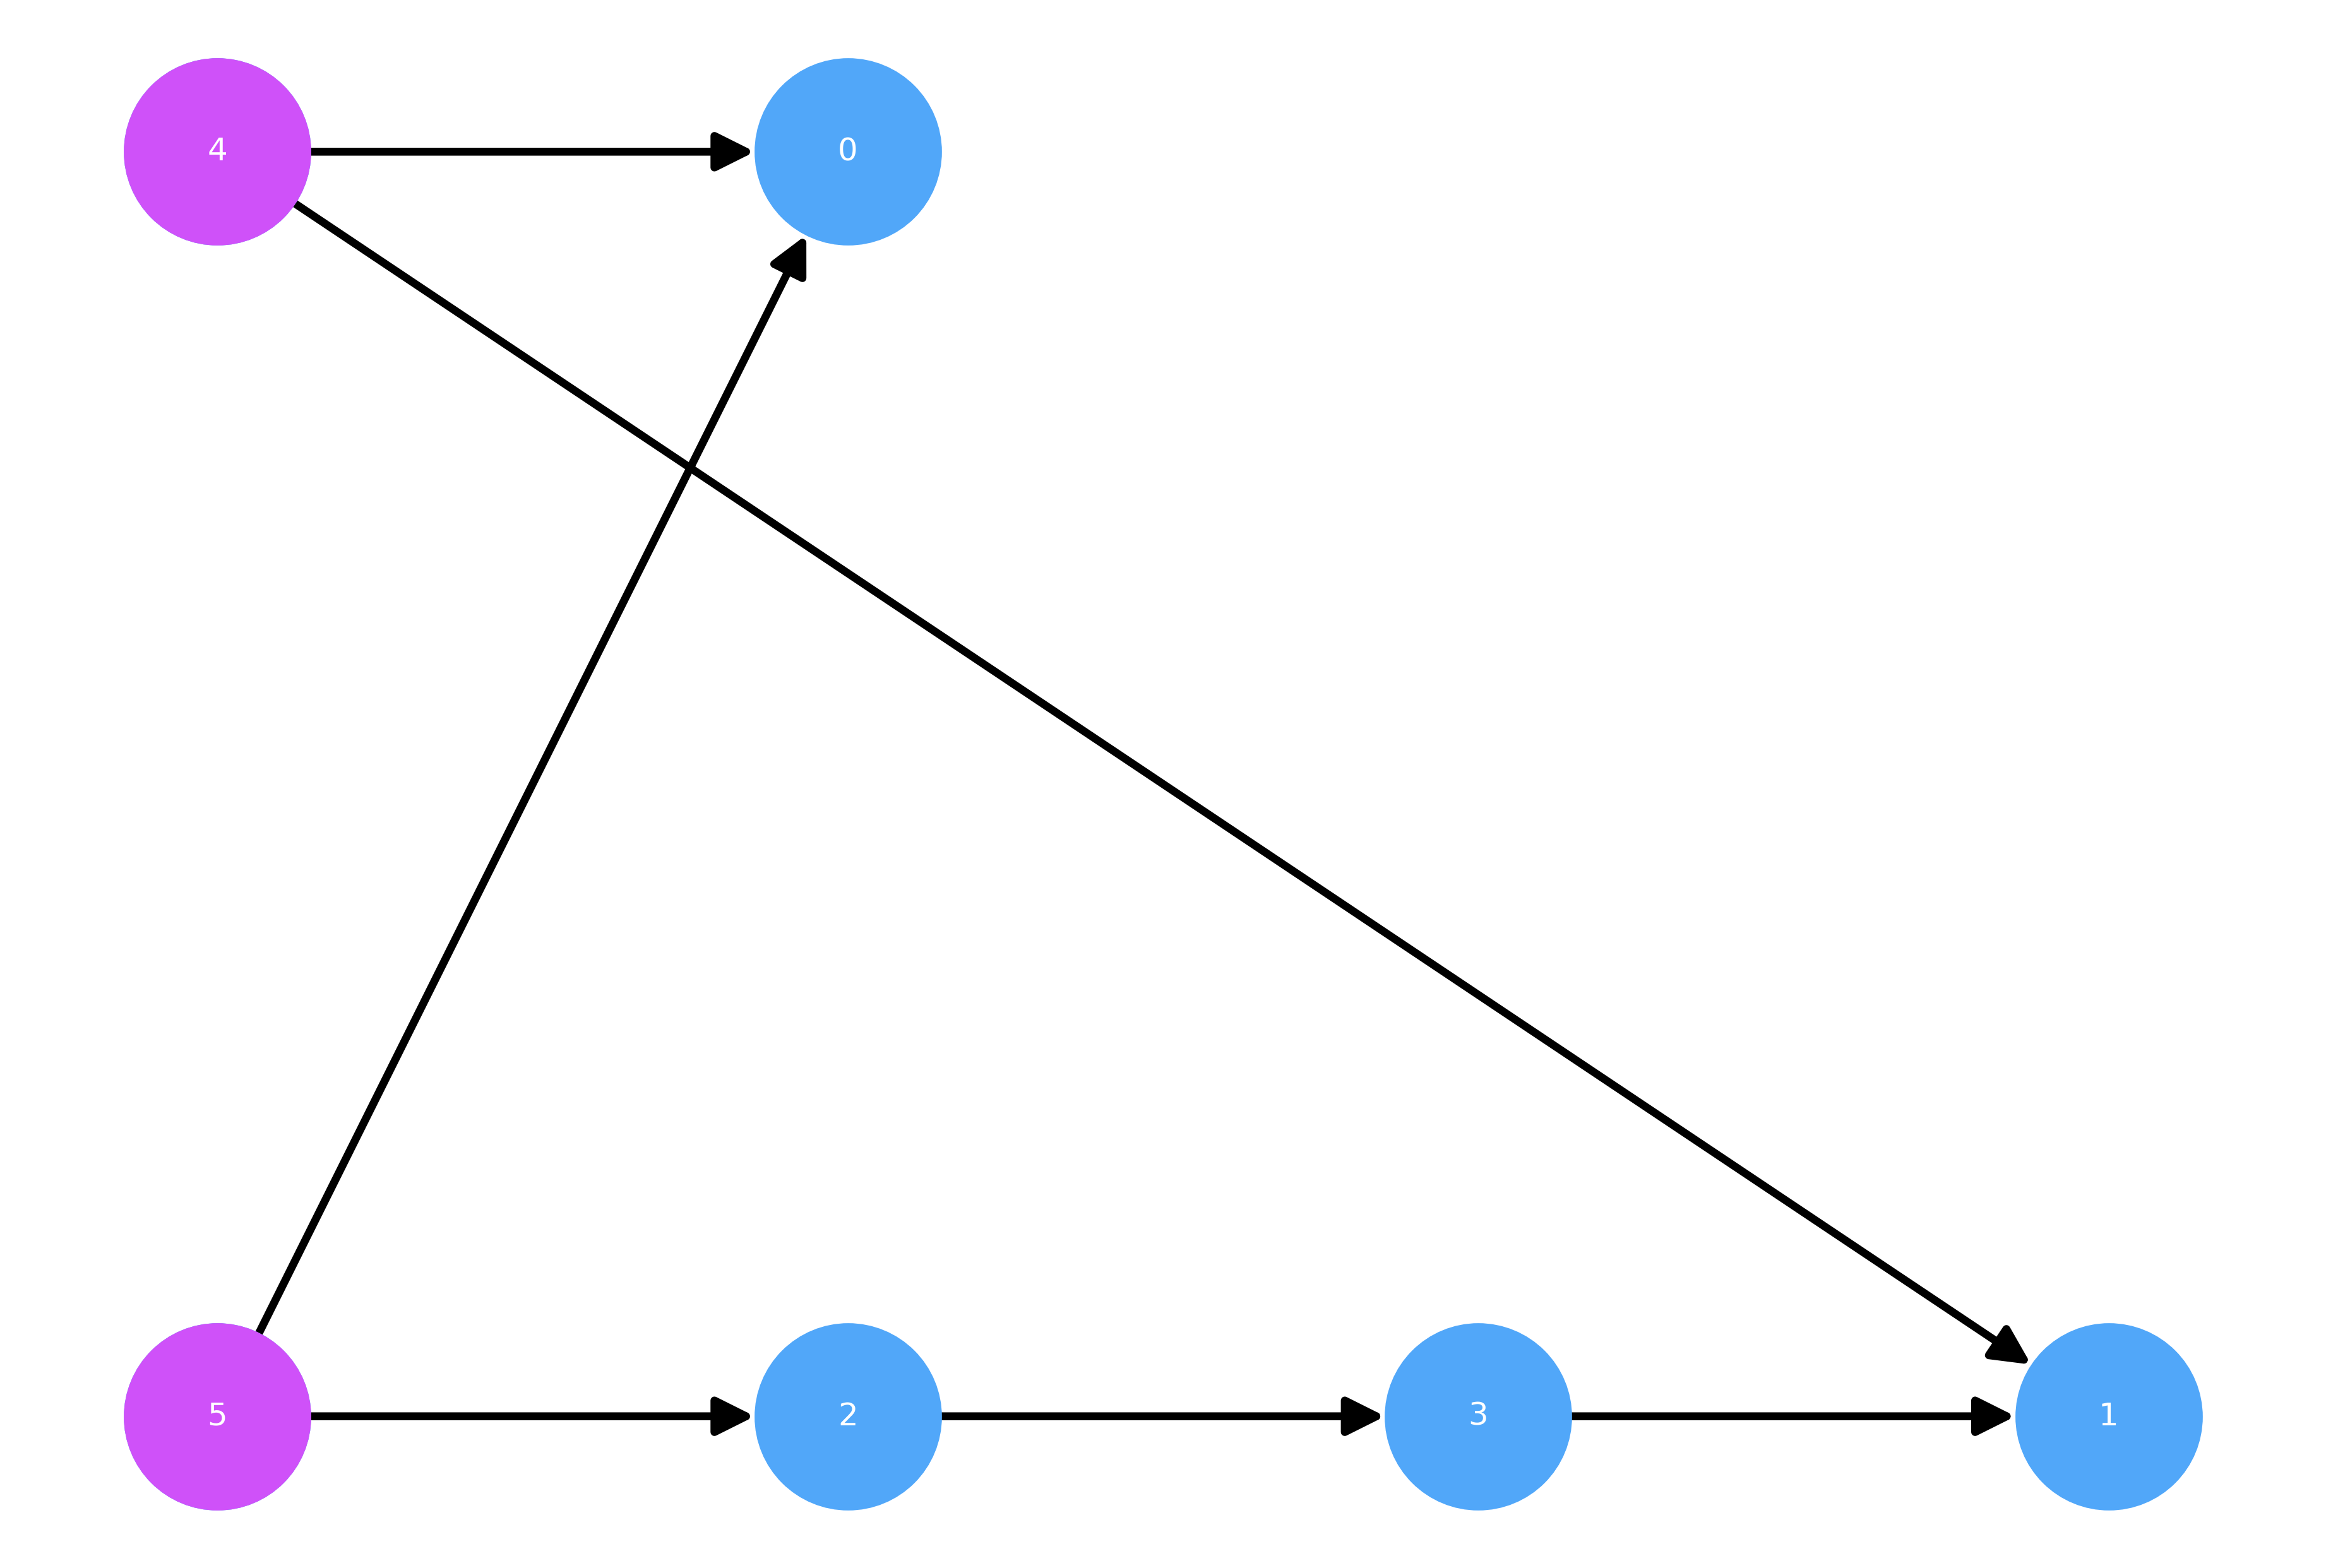

In [12]:
fig, ax = plt.subplots(1)
nx.draw(G, node_size=5000, pos=pos, node_color=colors[0], ax=ax, 
        width=3, arrowsize=30)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)
nx.draw_networkx_nodes(G, pos=pos, nodelist=zero_degree_nodes, 
                       node_color=colors[1], node_size=5000)

Let's try adding a loop in our DAG

In [13]:
G.add_edge(0, 3)
G.add_edge(3, 4)

Just to check

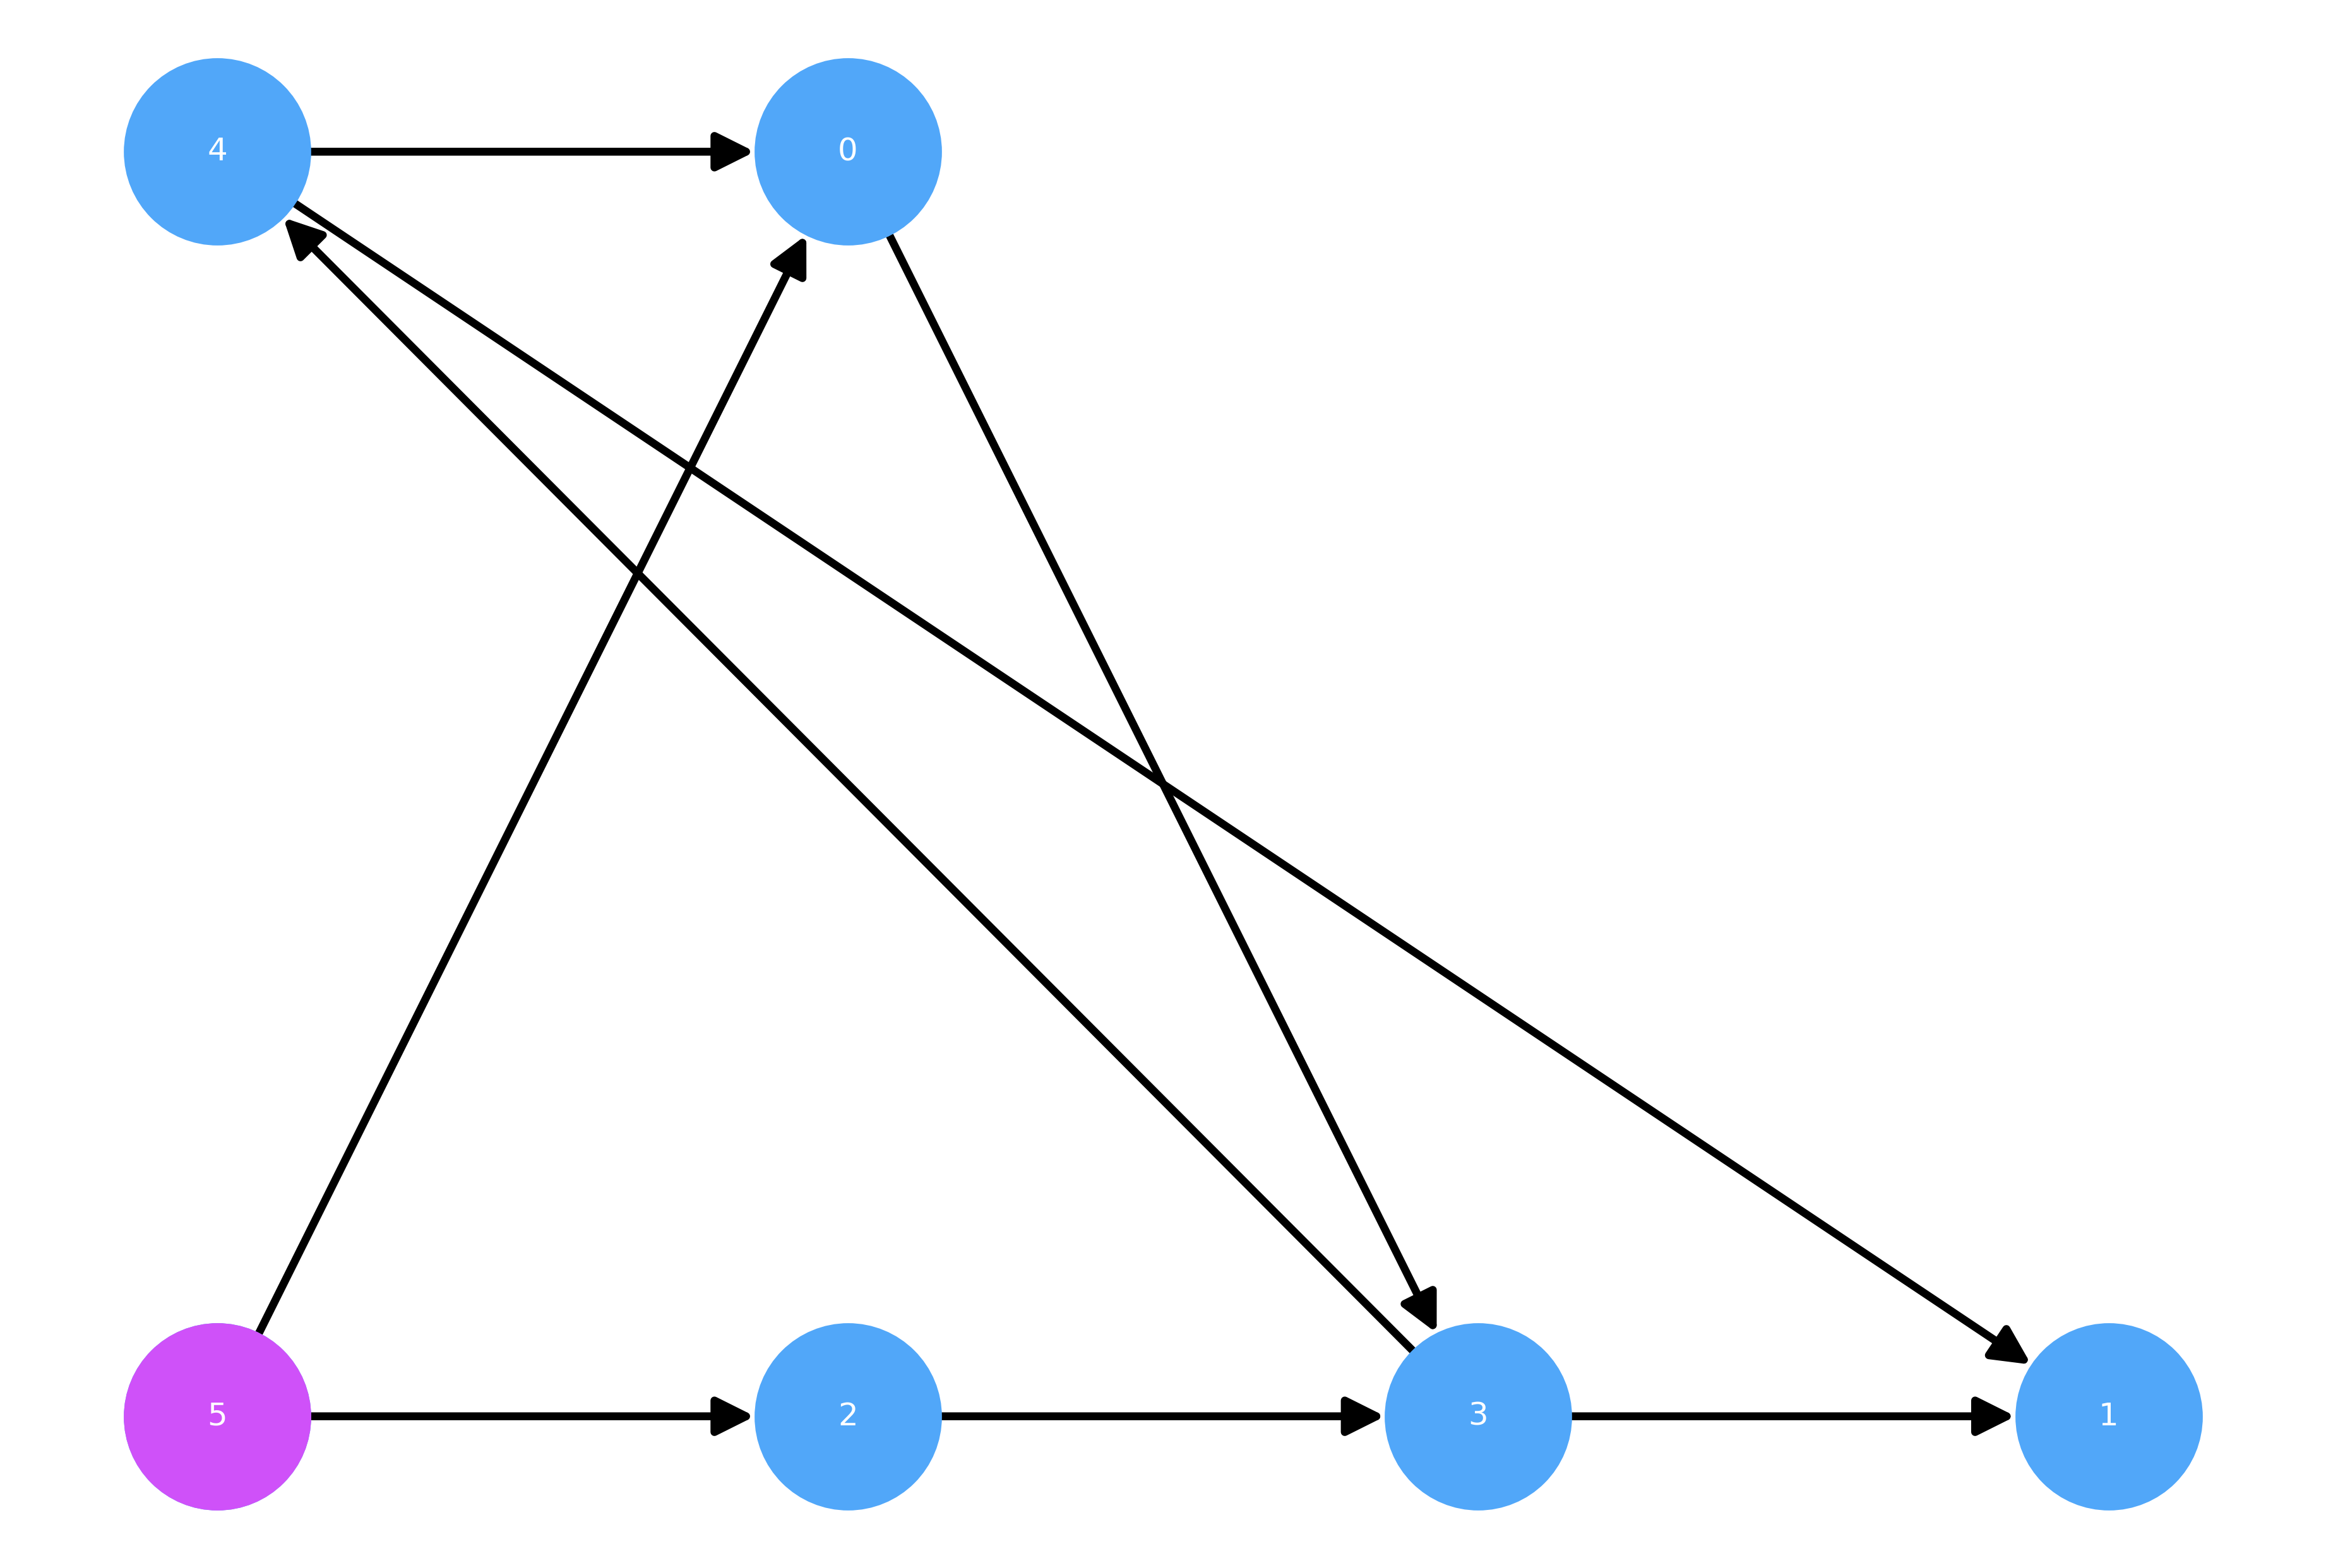

In [14]:
degrees = dict(G.in_degree())
zero_degree_nodes = [node for node, deg in degrees.items() if deg == 0]

fig, ax = plt.subplots(1)
nx.draw(G, node_size=5000, pos=pos, node_color=colors[0], ax=ax, 
        width=3, arrowsize=30)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)
nx.draw_networkx_nodes(G, pos=pos, nodelist=zero_degree_nodes, 
                       node_color=colors[1], node_size=5000)

It's clear that we now have a $$4 \to 0 \to 3 \to 4$$ loop in the graph. If we now try to recompute the topological ordering of the graph:

In [15]:
 node_order, depth = kahns_algorithm(G)

Ordered 2 nodes out of 6.


The algorithm terminates before visiting all the nodes as it runs out of zero-degree nodes in the queue

In [16]:
node_order

[5, 2]

In [17]:
depth

{5: 0, 2: 1}

# Citation Network

We start by loading our dataset

In [18]:
citations = pd.read_csv('data/cit-HepTh.txt', comment="#", sep='\t', 
                        header=None, dtype='str')

And converting it into a Directed Graph

In [19]:
G = nx.DiGraph()
G.add_edges_from(list(citations.values))

Next we extract the set of weakly connected components

In [20]:
comps = list(nx.weakly_connected_components(G))

we have over 140 individual components

In [30]:
len(comps)

143

In [31]:
sizes = [len(comp) for comp in comps]

Most of which have relatively small size. 

In [34]:
sorted(sizes)[-10:]

[5, 5, 5, 5, 5, 6, 6, 8, 10, 27400]

Let us start with a the second largest weakly connected component, of just 10 nodes

In [35]:
G2 = nx.subgraph(G, comps[4])

We can visualize it easily

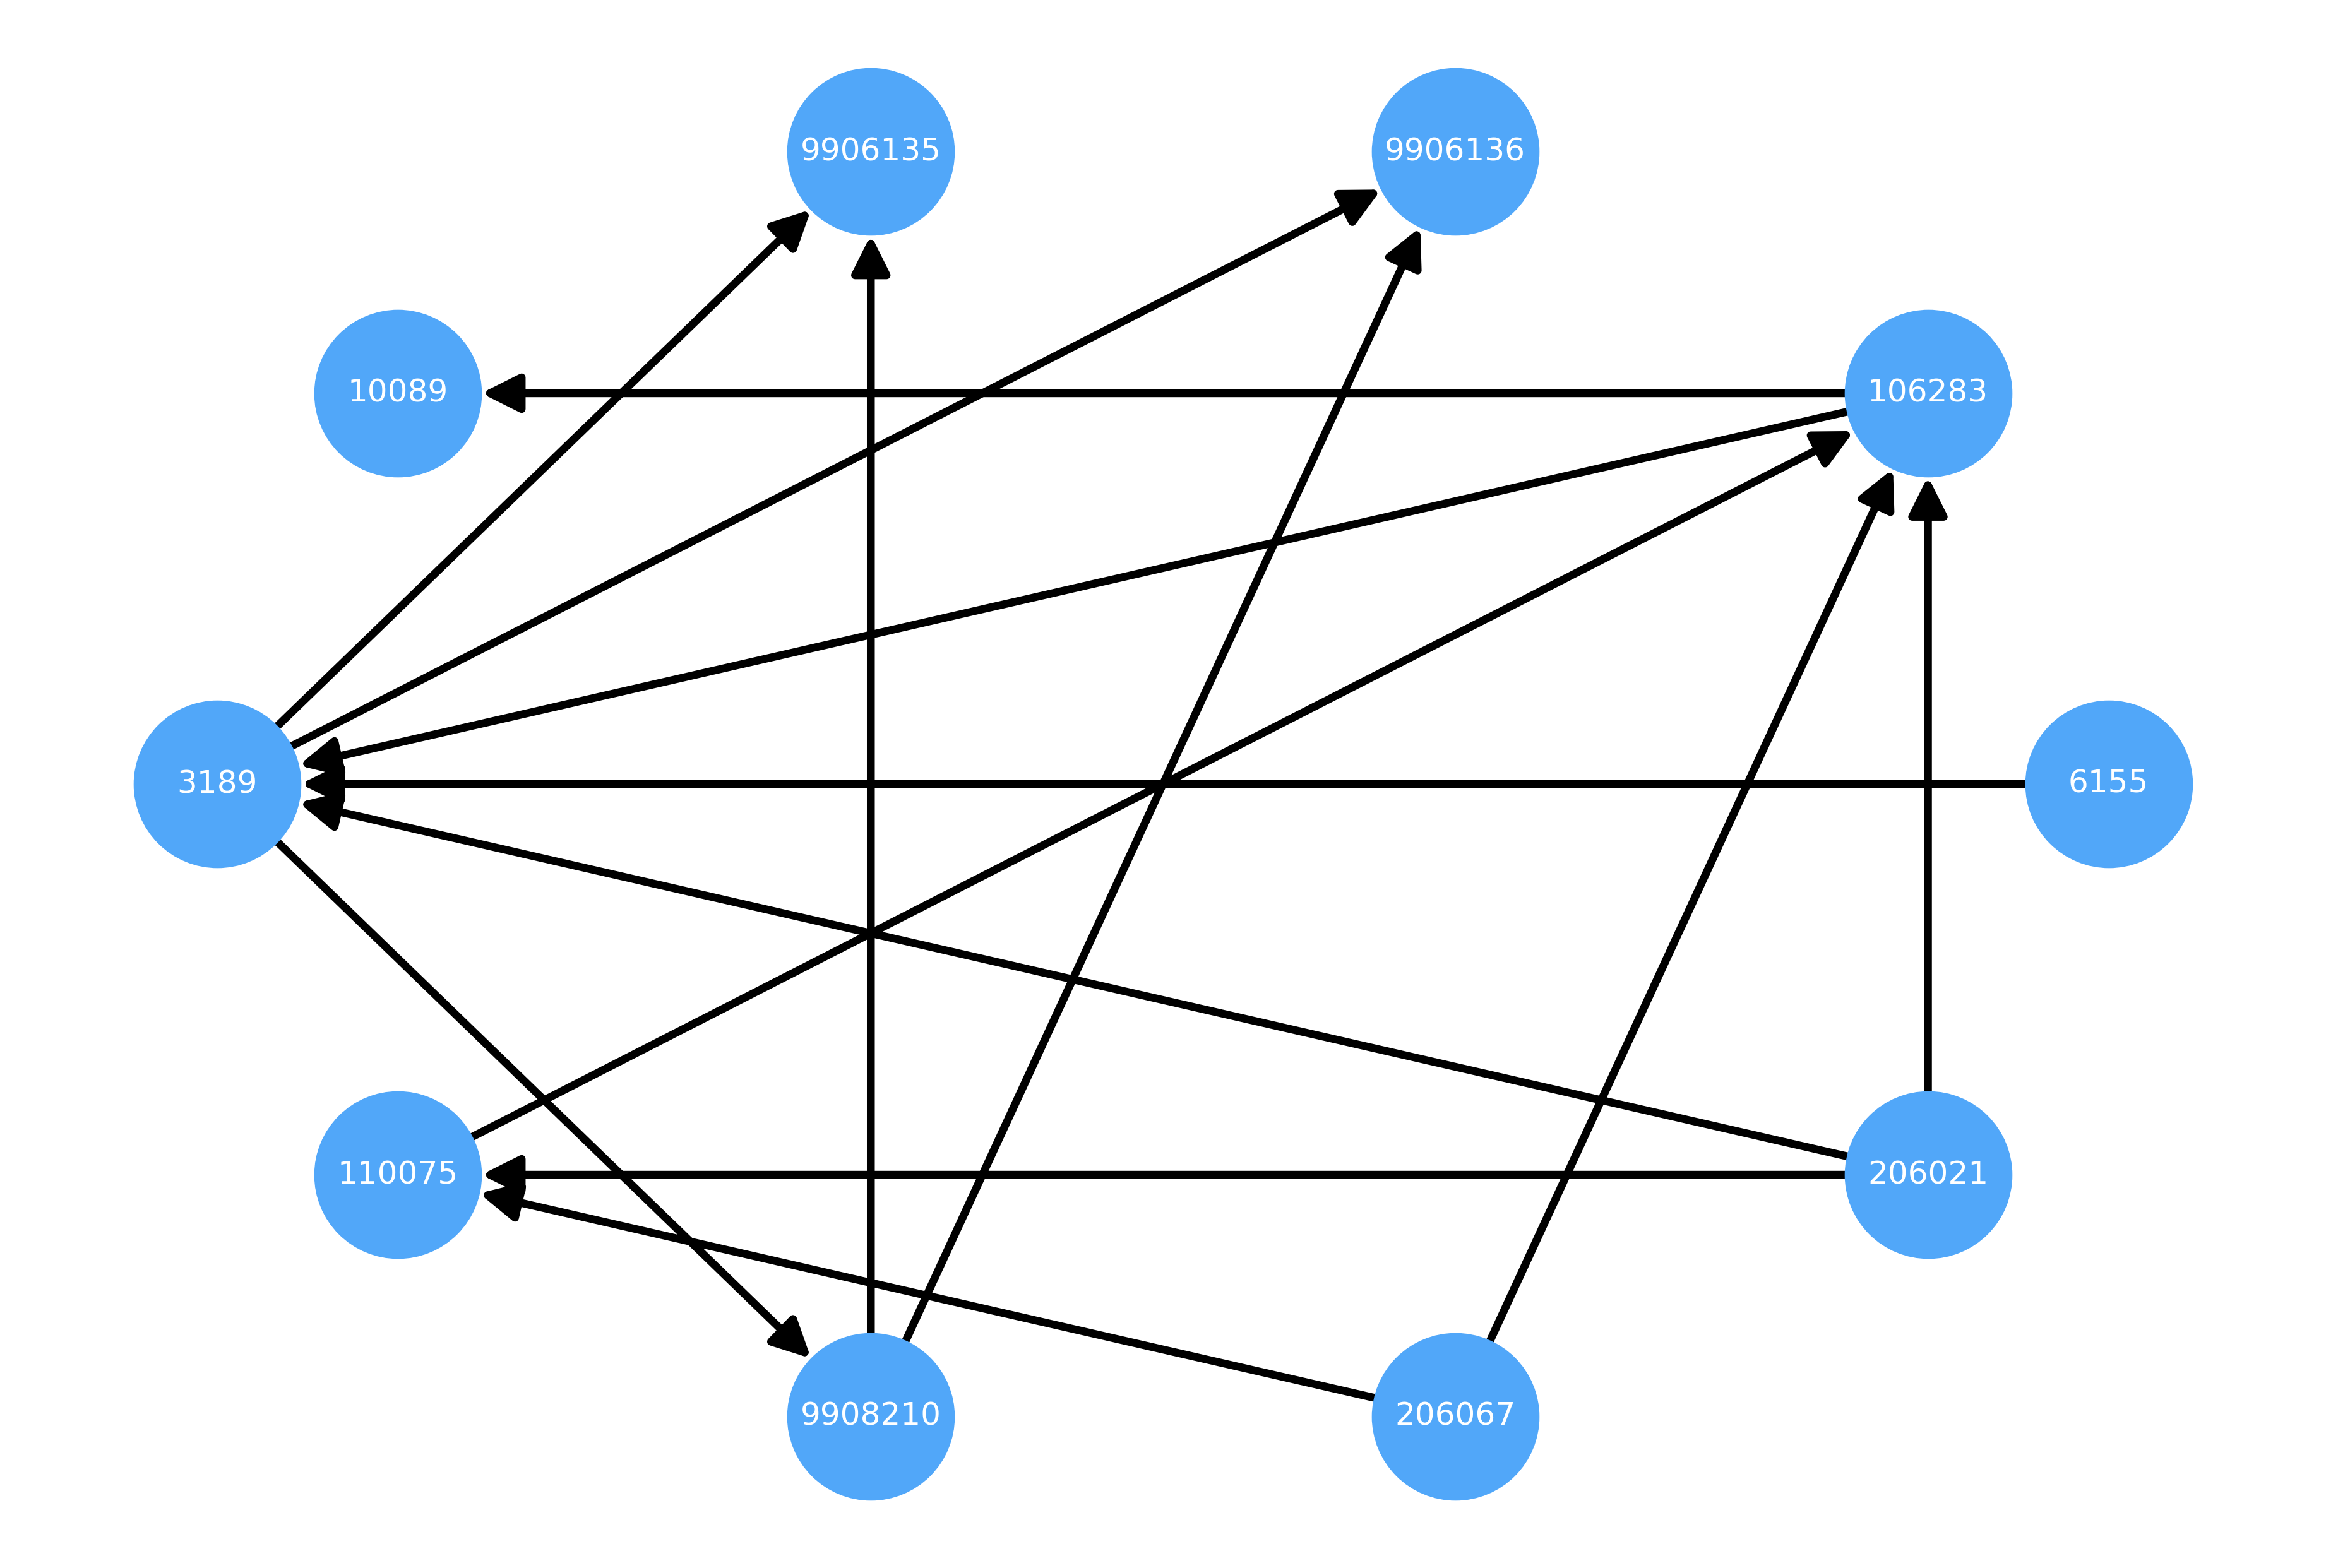

In [24]:
np.random.seed(123)
pos = nx.layout.shell_layout(G2)

fig, ax = plt.subplots(1)
nx.draw(G2, node_size=4000, pos=pos,  node_color=colors[0], ax=ax, 
        width=3, arrowsize=30)
nx.draw_networkx_labels(G2, pos=pos, font_color='white', ax=ax);

In [25]:
node_order, depth = kahns_algorithm(G2)

Ordered 10 nodes out of 10.


In [26]:
pos = compute_layout(depth)
zero_degree_nodes = [node for node, deg in dict(G2.in_degree()).items() if deg == 0]

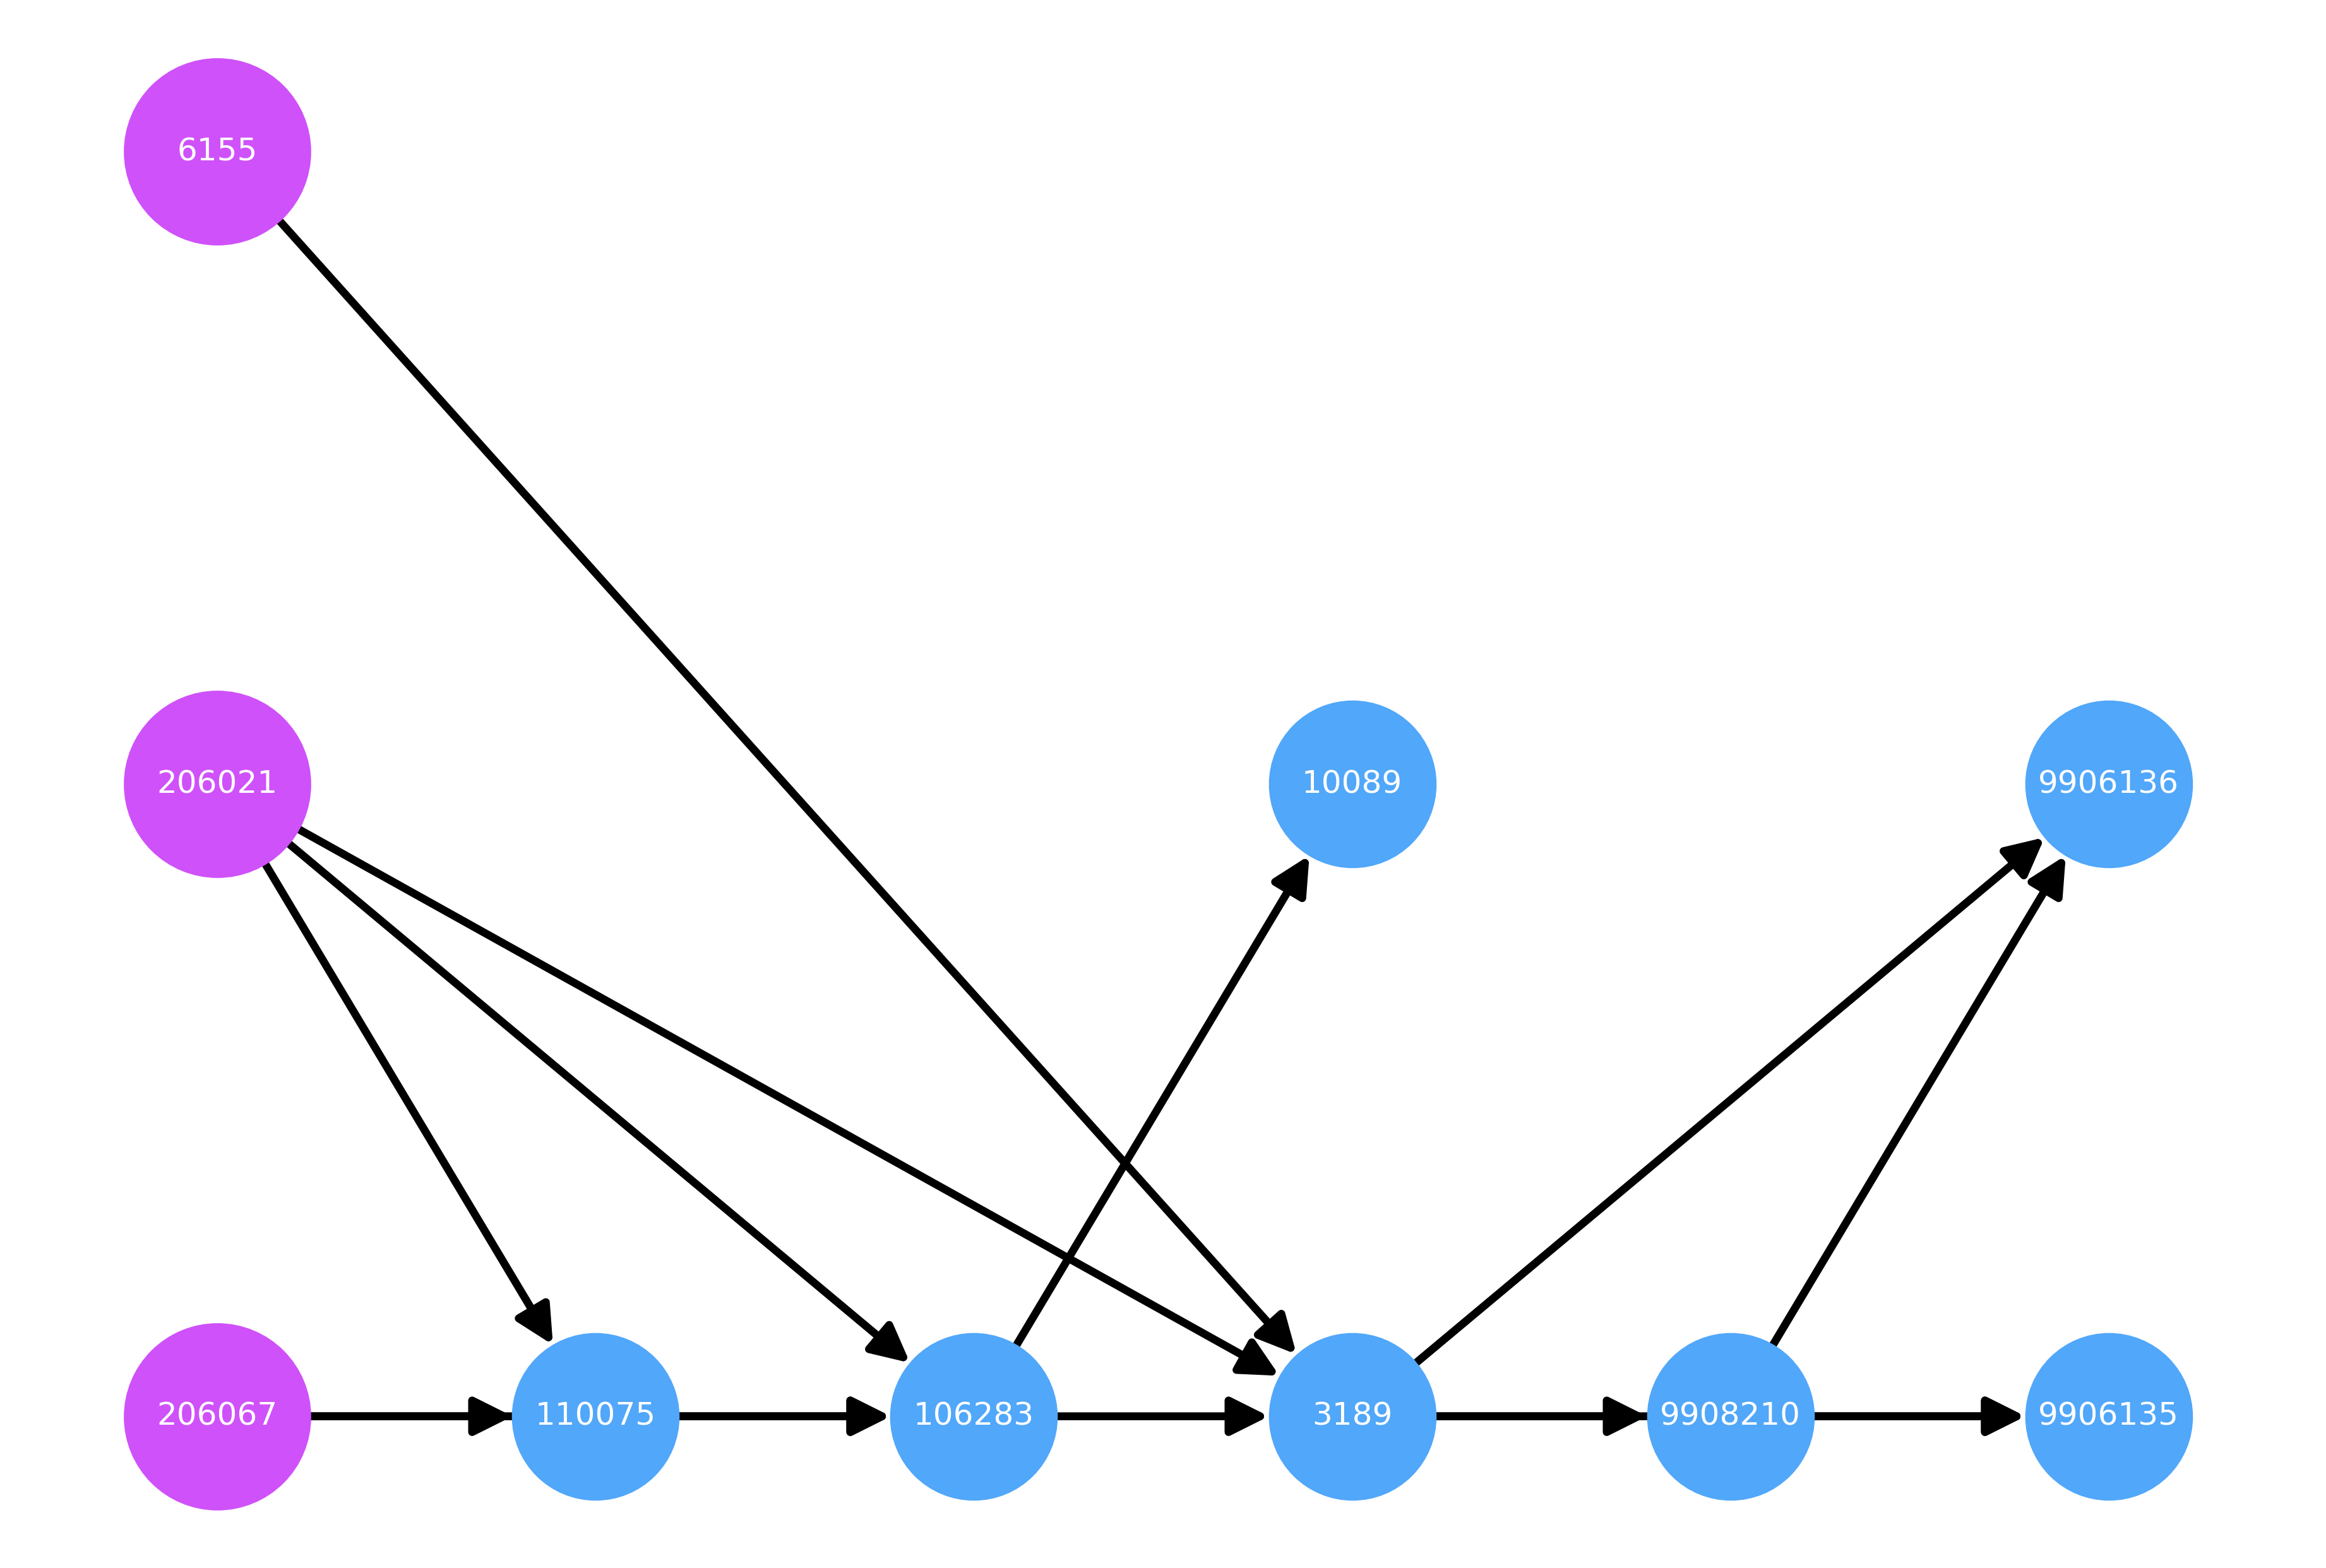

In [27]:
fig, ax = plt.subplots(1)
nx.draw(G2, pos=pos, node_size=4000, node_color=colors[0], ax=ax, width=3, arrowsize=30)
nx.draw_networkx_labels(G2, pos=pos, font_color='white')
nx.draw_networkx_nodes(G, pos=pos, nodelist=zero_degree_nodes, 
                       node_color=colors[1], node_size=5000)

Now, if we look at the largest connected component instead

In [28]:
G3 = nx.subgraph(G, comps[0])

And try to order it...

In [29]:
node_order, depth = kahns_algorithm(G3)

Ordered 9373 nodes out of 27400.


Indicating that the graph is not actually a DAG!

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>